Setup the environment to use TensorFlow, Keras, and Dataset (GOPRO,Berkely segmentation dataset 500 (BSD500)) manipulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import tensorflow as tf
from tensorflow.keras import layers, models

# For motion blur
import cv2

# For data loading & augmentation
import tensorflow_datasets as tfds


2025-04-26 23:06:36.233356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-26 23:06:36.447905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-26 23:06:36.513987: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-26 23:06:36.985071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-26 23:06:38.883529: W tensorflow/compiler/tf2

In [2]:
from tensorflow.image import psnr, ssim

def evaluate_psnr_ssim(model, dataset, max_val=1.0):
    psnr_vals = []
    ssim_vals = []

    for noisy, clean in dataset:
        denoised = model.predict(noisy, verbose=0)
        for i in range(denoised.shape[0]):
            psnr_val = psnr(clean[i], denoised[i], max_val=max_val).numpy()
            ssim_val = ssim(clean[i], denoised[i], max_val=max_val).numpy()
            psnr_vals.append(psnr_val)
            ssim_vals.append(ssim_val)

    mean_psnr = sum(psnr_vals) / len(psnr_vals)
    mean_ssim = sum(ssim_vals) / len(ssim_vals)
    return mean_psnr, mean_ssim


In [3]:
import os
import numpy as np
from PIL import Image

def load_gopro_dataset(blur_dir, sharp_dir, image_size=(256, 256), limit=None):
    X_blur = []
    Y_sharp = []

    blur_images = sorted(os.listdir(blur_dir))[:limit]
    for img_name in blur_images:
        blur_path = os.path.join(blur_dir, img_name)
        sharp_path = os.path.join(sharp_dir, img_name)  # same filename assumed

        # Load and preprocess
        blur_img = Image.open(blur_path).convert('L').resize(image_size)
        sharp_img = Image.open(sharp_path).convert('L').resize(image_size)

        # Normalize and expand dims to (H, W, 1)
        blur_np = np.expand_dims(np.array(blur_img).astype('float32') / 255., axis=-1)
        sharp_np = np.expand_dims(np.array(sharp_img).astype('float32') / 255., axis=-1)


        # Ensure 3 channels
        if blur_np.ndim == 2:
            blur_np = np.expand_dims(blur_np, -1)
        if sharp_np.ndim == 2:
            sharp_np = np.expand_dims(sharp_np, -1)

        X_blur.append(blur_np)
        Y_sharp.append(sharp_np)

    return np.array(X_blur), np.array(Y_sharp)


In [4]:
def load_gopro_dataset_all(data_dir, image_size=(256, 256), limit_per_sequence=None):
    def load_split(split):
        X_total, Y_total = [], []
        split_path = os.path.join(data_dir, split)
        sequences = sorted(os.listdir(split_path))

        for seq in sequences:
            blur_dir = os.path.join(split_path, seq, "blur")
            sharp_dir = os.path.join(split_path, seq, "sharp")

            if os.path.exists(blur_dir) and os.path.exists(sharp_dir):
                print(f"Loading {split}/{seq}...")
                X_blur, Y_sharp = load_gopro_dataset(
                    blur_dir, sharp_dir,
                    image_size=image_size,
                    limit=limit_per_sequence
                )
                X_total.extend(X_blur)
                Y_total.extend(Y_sharp)

        return np.array(X_total), np.array(Y_total)

    X_train, Y_train = load_split("train")
    X_test, Y_test = load_split("test")
    return (X_train, Y_train), (X_test, Y_test)


In [5]:
def add_gaussian_noise(img_array, mean=0.0, std=0.05):
    noise = np.random.normal(mean, std, img_array.shape)
    noisy_img = img_array + noise
    return np.clip(noisy_img, 0., 1.)

In [6]:
def process_bsd500_gaussian_blur_noise(image_dir, image_size=(256, 256), limit=None, blur_radius=2.5, noise_std=0.05):
    X_clean = []
    X_noisy = []

    image_files = sorted(os.listdir(image_dir))[:limit]

    for fname in image_files:
        path = os.path.join(image_dir, fname)
        try:
            img = Image.open(path).convert('L').resize(image_size)

            # Original clean image
            clean_np = np.array(img).astype('float32') / 255.
            clean_np = np.expand_dims(clean_np, axis=-1)  # Add channel dim (H, W, 1)

            # Apply Gaussian blur
            blurred_img = img.filter(ImageFilter.GaussianBlur(radius=blur_radius))
            blurred_np = np.array(blurred_img).astype('float32') / 255.
            blurred_np = np.expand_dims(blurred_np, axis=-1)  # Add channel dim (H, W, 1)

            # Add Gaussian noise
            noisy_np = add_gaussian_noise(blurred_np, std=noise_std)

            X_clean.append(clean_np)
            X_noisy.append(noisy_np)
        except Exception as e:
            print(f"Error processing {path}: {e}")

    return np.array(X_noisy), np.array(X_clean)



In [7]:
import tensorflow as tf

def create_tf_dataset(X_input, X_target, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X_input, X_target))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X_input))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

"""def create_tf_dataset(X_input, X_target, batch_size=16, shuffle=True):
    def gen():
        for x, y in zip(X_input, X_target):
            yield x, y

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=X_input.shape[1:], dtype=tf.float32),
            tf.TensorSpec(shape=X_target.shape[1:], dtype=tf.float32)
        )
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1024)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset """


'def create_tf_dataset(X_input, X_target, batch_size=16, shuffle=True):\n    def gen():\n        for x, y in zip(X_input, X_target):\n            yield x, y\n\n    dataset = tf.data.Dataset.from_generator(\n        gen,\n        output_signature=(\n            tf.TensorSpec(shape=X_input.shape[1:], dtype=tf.float32),\n            tf.TensorSpec(shape=X_target.shape[1:], dtype=tf.float32)\n        )\n    )\n\n    if shuffle:\n        dataset = dataset.shuffle(buffer_size=1024)\n\n    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)\n    return dataset '

In [8]:
from tensorflow.keras import layers, Model

def build_pres_unet(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(64, 3, padding="same", activation="relu")(p1)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(128, 3, padding="same", activation="relu")(p2)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    c4 = layers.Conv2D(256, 3, padding="same", activation="relu")(p3)
    c4 = layers.BatchNormalization()(c4)
    p4 = layers.MaxPooling2D(2)(c4)

    # Bottleneck
    bn = layers.Conv2D(512, 3, padding="same", activation="relu")(p4)
    bn = layers.BatchNormalization()(bn)

    # Decoder
    u4 = layers.UpSampling2D(2)(bn)
    u4 = layers.Concatenate()([u4, c4])
    d4 = layers.Conv2D(256, 3, padding="same", activation="relu")(u4)
    d4 = layers.BatchNormalization()(d4)

    u3 = layers.UpSampling2D(2)(d4)
    u3 = layers.Concatenate()([u3, c3])
    d3 = layers.Conv2D(128, 3, padding="same", activation="relu")(u3)
    d3 = layers.BatchNormalization()(d3)

    u2 = layers.UpSampling2D(2)(d3)
    u2 = layers.Concatenate()([u2, c2])
    d2 = layers.Conv2D(64, 3, padding="same", activation="relu")(u2)
    d2 = layers.BatchNormalization()(d2)

    u1 = layers.UpSampling2D(2)(d2)
    u1 = layers.Concatenate()([u1, c1])
    d1 = layers.Conv2D(32, 3, padding="same", activation="relu")(u1)
    d1 = layers.BatchNormalization()(d1)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d1)

    return Model(inputs, outputs, name="PresUNet")


In [9]:
"""from tensorflow.keras import layers, Model

def build_autoencoder_v2(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)  # 128x128

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)  # 64x64

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)  # 32x32

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)  # 16x16

    # Bottleneck
    bn = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    bn = layers.Conv2D(1024, 3, activation='relu', padding='same')(bn)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(bn)
    u4 = layers.Concatenate()([u4, c4])
    c5 = layers.Conv2D(512, 3, activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(512, 3, activation='relu', padding='same')(c5)

    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same')(c6)

    u2 = layers.UpSampling2D((2, 2))(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same')(c7)

    u1 = layers.UpSampling2D((2, 2))(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(c8)

    return Model(inputs, outputs, name="DeepUNetAutoencoder")
"""

'from tensorflow.keras import layers, Model\n\ndef build_autoencoder_v2(input_shape=(256, 256, 1)):\n    inputs = layers.Input(shape=input_shape)\n\n    # Encoder\n    c1 = layers.Conv2D(64, 3, activation=\'relu\', padding=\'same\')(inputs)\n    c1 = layers.Conv2D(64, 3, activation=\'relu\', padding=\'same\')(c1)\n    p1 = layers.MaxPooling2D((2, 2))(c1)  # 128x128\n\n    c2 = layers.Conv2D(128, 3, activation=\'relu\', padding=\'same\')(p1)\n    c2 = layers.Conv2D(128, 3, activation=\'relu\', padding=\'same\')(c2)\n    p2 = layers.MaxPooling2D((2, 2))(c2)  # 64x64\n\n    c3 = layers.Conv2D(256, 3, activation=\'relu\', padding=\'same\')(p2)\n    c3 = layers.Conv2D(256, 3, activation=\'relu\', padding=\'same\')(c3)\n    p3 = layers.MaxPooling2D((2, 2))(c3)  # 32x32\n\n    c4 = layers.Conv2D(512, 3, activation=\'relu\', padding=\'same\')(p3)\n    c4 = layers.Conv2D(512, 3, activation=\'relu\', padding=\'same\')(c4)\n    p4 = layers.MaxPooling2D((2, 2))(c4)  # 16x16\n\n    # Bottleneck\n  

In [10]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available:", gpus[0])
else:
    print("No GPU detected — training may be slow.")


GPU is available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1745708803.750160   28760 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745708804.339665   28760 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745708804.343190   28760 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [11]:
if __name__ == '__main__':
    # Load the dataset
    # Make sure to set the correct path to your dataset
    # The dataset should be structured as:
    # GoPro/
    # ├── train/
    # │   ├── sequence_1/
    # │   │   ├── blur/
    # |   |   ├── blur_gamma
    # │   │   └── sharp/
    # │   └── sequence_2/
    # │       ├── blur/
    # |       ├── blur_gamma
    # │       └── sharp/
    # └── test/
    #     ├── sequence_1/
    #     │   ├── blur/
    #     |   ├── blur_gamma
    #     │   └── sharp/
    #     └── sequence_2/
    #         ├── blur/
    #         ├── blur_gamma
    #         └── sharp/


    # BSDS500/ 
    #       ├── images/
    #       │   │   ├── train/
    #       │   │   ├── test/
    #       │   │   └── val/
    #       │   └── groundTruth/
    #       │       ├── train/
    #       │       ├── test/
    #       │       └── val/


    # === GoPro Dataset ===
    data_path = "../../../GOPRO"  # adjust as needed
    (X_train_gopro, Y_train_gopro), (X_test_gopro, Y_test_gopro) = load_gopro_dataset_all(
        data_dir=data_path,
        image_size=(256, 256),
        limit_per_sequence=200
    )
    print("GoPro train:", X_train_gopro.shape, Y_train_gopro.shape)
    print("GoPro test:", X_test_gopro.shape, Y_test_gopro.shape)

    test_dataset_gopro = create_tf_dataset(X_test_gopro, Y_test_gopro, batch_size=16, shuffle=False)

    from sklearn.model_selection import train_test_split

    # Split 10% of training into validation set
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_train_gopro, Y_train_gopro, test_size=0.1, random_state=42
    )

    # === BSD500 Dataset ===
    bsd_path = "../../../BSD500/images/train"  # update this to your extracted BSD path

    X_bsd_blur, X_bsd_clean = process_bsd500_gaussian_blur_noise(
        image_dir=bsd_path,
        image_size=(256, 256),
        limit=200,
        blur_radius=2.5,
        noise_std=0.05
    )
    print("BSD500 processed:", X_bsd_blur.shape, X_bsd_clean.shape)

    # === Convert BSD to tf.data.Dataset ===
    bsd_dataset = create_tf_dataset(X_bsd_blur, X_bsd_clean, batch_size=16)

    #show a batch
    for noisy, clean in bsd_dataset.take(1):
        print("Batch sample shapes:", noisy.shape, clean.shape)
    

    # Combine BSD500 + GoPro training data
    X_combined = np.concatenate([X_bsd_blur, X_train], axis=0)
    Y_combined = np.concatenate([X_bsd_clean, Y_train], axis=0)

    print("Combined training dataset shape:", X_combined.shape)
    print("→ From BSD500:", X_bsd_blur.shape[0])
    print("→ From GoPro:", X_train.shape[0])


    # === BSD500 Validation ===
    bsd_val_path = "../../../BSD500/images/val"
    X_val_bsd_blur, X_val_bsd_clean = process_bsd500_gaussian_blur_noise(
        image_dir=bsd_val_path,
        image_size=(256, 256),
        limit=None,
        blur_radius=2.5,
        noise_std=0.05
    )
    val_dataset_bsd = create_tf_dataset(X_val_bsd_blur, X_val_bsd_clean, batch_size=16, shuffle=False)

    bsd_test_path = "../../../BSD500/images/test"
    X_test_bsd_blur, X_test_bsd_clean = process_bsd500_gaussian_blur_noise(
        image_dir=bsd_test_path,
        image_size=(256, 256),
        limit=None,
        blur_radius=2.5,
        noise_std=0.05
    )
    test_dataset_bsd = create_tf_dataset(X_test_bsd_blur, X_test_bsd_clean, batch_size=16, shuffle=False)

    train_dataset = create_tf_dataset(X_combined, Y_combined, batch_size=16)
    val_dataset   = create_tf_dataset(X_val, Y_val, batch_size=16, shuffle=False)



Loading train/GOPR0372_07_00...
Loading train/GOPR0372_07_01...
Loading train/GOPR0374_11_00...
Loading train/GOPR0374_11_01...
Loading train/GOPR0374_11_02...
Loading train/GOPR0374_11_03...
Loading train/GOPR0378_13_00...
Loading train/GOPR0379_11_00...
Loading train/GOPR0380_11_00...
Loading train/GOPR0384_11_01...
Loading train/GOPR0384_11_02...
Loading train/GOPR0384_11_03...
Loading train/GOPR0384_11_04...
Loading train/GOPR0385_11_00...
Loading train/GOPR0386_11_00...
Loading train/GOPR0477_11_00...
Loading train/GOPR0857_11_00...
Loading train/GOPR0868_11_01...
Loading train/GOPR0868_11_02...
Loading train/GOPR0871_11_01...
Loading train/GOPR0881_11_00...
Loading train/GOPR0884_11_00...
Loading test/GOPR0384_11_00...
Loading test/GOPR0384_11_05...
Loading test/GOPR0385_11_01...
Loading test/GOPR0396_11_00...
Loading test/GOPR0410_11_00...
Loading test/GOPR0854_11_00...
Loading test/GOPR0862_11_00...
Loading test/GOPR0868_11_00...
Loading test/GOPR0869_11_00...
Loading test/GOPR

I0000 00:00:1745709008.251928   28760 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745709008.256000   28760 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745709008.259057   28760 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745709008.429572   28760 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

BSD500 processed: (200, 256, 256, 1) (200, 256, 256, 1)
Batch sample shapes: (16, 256, 256, 1) (16, 256, 256, 1)


2025-04-26 23:10:11.634731: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Combined training dataset shape: (2092, 256, 256, 1)
→ From BSD500: 200
→ From GoPro: 1892
Error processing ../../../BSD500/images/val/Thumbs.db: cannot identify image file '../../../BSD500/images/val/Thumbs.db'
Error processing ../../../BSD500/images/test/Thumbs.db: cannot identify image file '../../../BSD500/images/test/Thumbs.db'


2025-04-26 23:10:15.543766: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1096810496 exceeds 10% of free system memory.
2025-04-26 23:10:16.688201: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 548405248 exceeds 10% of free system memory.
2025-04-26 23:10:17.089264: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1096810496 exceeds 10% of free system memory.
2025-04-26 23:10:17.721244: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 548405248 exceeds 10% of free system memory.


In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save the best model based on validation loss
checkpoint_cb = ModelCheckpoint(
    "best_model.h5",  # Save to file
    save_best_only=True,
    monitor="val_loss", 
    mode="min",  # Lower val_loss is better
    verbose=1
)

# Stop training early if no improvement after 5 epochs
earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

callbacks_list = [checkpoint_cb, earlystop_cb]


In [20]:
# === Build and compile model ===
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import AdamW
import tensorflow.image as tfi

def psnr_metric(y_true, y_pred):
    return tfi.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tfi.ssim(y_true, y_pred, max_val=1.0)

EPOCHS = 35

# Cosine decay: starts at 1e-3 and decays over 35 epochs
steps_per_epoch = len(train_dataset)
total_steps = steps_per_epoch * EPOCHS

lr_schedule = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=total_steps,
    alpha=1e-2  # final learning rate = alpha * initial_learning_rate
)


def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    return 0.5 * mse + 0.5 * mae

autoencoder = build_pres_unet(input_shape=(256, 256, 1))
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer=AdamW(learning_rate=lr_schedule), loss=combined_loss, metrics=[psnr_metric, ssim_metric])

train_losses = []
val_losses_gopro = []
val_losses_bsd = []



for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    learning_rates = []

    # 1. Train for 1 epoch
    history = autoencoder.fit(train_dataset, validation_data=val_dataset, epochs=1, verbose=1, callbacks=callbacks_list)

    # 2. Save training + GoPro val loss
    train_losses.append(history.history['loss'][0])
    val_losses_gopro.append(history.history['val_loss'][0])

    # 3. Evaluate on BSD500 val set
    val_loss_bsd = autoencoder.evaluate(val_dataset_bsd, verbose=0)
    val_losses_bsd.append(val_loss_bsd)

    current_step = autoencoder.optimizer.iterations.numpy()

    # Check if learning_rate is a schedule or a fixed tensor
    if callable(autoencoder.optimizer.learning_rate):
        current_lr = tf.keras.backend.get_value(autoencoder.optimizer.learning_rate(current_step))
    else:
        current_lr = tf.keras.backend.get_value(autoencoder.optimizer.learning_rate)

    learning_rates.append(current_lr)
    print(f"Current LR: {current_lr:.6f}")







Epoch 1/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0439 - psnr_metric: 21.8668 - ssim_metric: 0.6773
Epoch 1: val_loss did not improve from 0.09907
131/131 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - loss: 0.0438 - psnr_metric: 21.8849 - ssim_metric: 0.6779 - val_loss: 0.1012 - val_psnr_metric: 14.3169 - val_ssim_metric: 0.4387
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000998

Epoch 2/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0206 - psnr_metric: 25.9146 - ssim_metric: 0.7993
Epoch 1: val_loss improved from 0.09907 to 0.08391, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0206 - psnr_metric: 25.9151 - ssim_metric: 0.7993 - val_loss: 0.0839 - val_psnr_metric: 15.6397 - val_ssim_metric: 0.5163
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000992

Epoch 3/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0200 - psnr_metric: 26.2097 - ssim_metric: 0.8032
Epoch 1: val_loss improved from 0.08391 to 0.06127, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0200 - psnr_metric: 26.2098 - ssim_metric: 0.8032 - val_loss: 0.0613 - val_psnr_metric: 17.8889 - val_ssim_metric: 0.6280
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000982

Epoch 4/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0199 - psnr_metric: 26.2349 - ssim_metric: 0.8059
Epoch 1: val_loss improved from 0.06127 to 0.03473, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0199 - psnr_metric: 26.2344 - ssim_metric: 0.8059 - val_loss: 0.0347 - val_psnr_metric: 22.2564 - val_ssim_metric: 0.7430
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000968

Epoch 5/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0194 - psnr_metric: 26.3954 - ssim_metric: 0.8086
Epoch 1: val_loss improved from 0.03473 to 0.01893, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0194 - psnr_metric: 26.3961 - ssim_metric: 0.8086 - val_loss: 0.0189 - val_psnr_metric: 26.3415 - val_ssim_metric: 0.8144
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000951

Epoch 6/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0191 - psnr_metric: 26.5857 - ssim_metric: 0.8094
Epoch 1: val_loss improved from 0.01893 to 0.01797, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0191 - psnr_metric: 26.5858 - ssim_metric: 0.8094 - val_loss: 0.0180 - val_psnr_metric: 26.6641 - val_ssim_metric: 0.8320
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000930

Epoch 7/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0188 - psnr_metric: 26.5963 - ssim_metric: 0.8157
Epoch 1: val_loss improved from 0.01797 to 0.01677, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0188 - psnr_metric: 26.5964 - ssim_metric: 0.8156 - val_loss: 0.0168 - val_psnr_metric: 27.2756 - val_ssim_metric: 0.8370
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000905

Epoch 8/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0181 - psnr_metric: 26.8930 - ssim_metric: 0.8156
Epoch 1: val_loss did not improve from 0.01677
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0181 - psnr_metric: 26.8928 - ssim_metric: 0.8156 - val_loss: 0.0185 - val_psnr_metric: 26.7430 - val_ssim_metric: 0.8370
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000878

Epoch 9/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0186 - psnr_metric: 26.7620 - ssim_metric: 0.8141
Epoch 1: val_loss did not improve from 0.01677
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0186 - psnr_metric: 26.7623 - ssim_metric: 0.8141 - val_loss: 0.0208 - val_psnr_metric: 25.6822 - val_ssim_metric: 0.8

131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0183 - psnr_metric: 26.8092 - ssim_metric: 0.8134 - val_loss: 0.0165 - val_psnr_metric: 27.1645 - val_ssim_metric: 0.8389
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000814

Epoch 11/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0185 - psnr_metric: 26.7498 - ssim_metric: 0.8194
Epoch 1: val_loss improved from 0.01648 to 0.01545, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0185 - psnr_metric: 26.7514 - ssim_metric: 0.8194 - val_loss: 0.0155 - val_psnr_metric: 27.7813 - val_ssim_metric: 0.8415
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000778

Epoch 12/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0182 - psnr_metric: 26.9160 - ssim_metric: 0.8209
Epoch 1: val_loss did not improve from 0.01545
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0182 - psnr_metric: 26.9168 - ssim_metric: 0.8209 - val_loss: 0.0198 - val_psnr_metric: 26.2223 - val_ssim_metric: 0.8369
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000740

Epoch 13/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0184 - psnr_metric: 26.9111 - ssim_metric: 0.8221
Epoch 1: val_loss did not improve from 0.01545
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0184 - psnr_metric: 26.9113 - ssim_metric: 0.8221 - val_loss: 0.0180 - val_psnr_metric: 26.8708 - val_ssim_metric: 0

131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0178 - psnr_metric: 27.0028 - ssim_metric: 0.8231 - val_loss: 0.0152 - val_psnr_metric: 27.9242 - val_ssim_metric: 0.8424
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000571

Epoch 17/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0175 - psnr_metric: 27.2370 - ssim_metric: 0.8276
Epoch 1: val_loss did not improve from 0.01517
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0175 - psnr_metric: 27.2364 - ssim_metric: 0.8276 - val_loss: 0.0163 - val_psnr_metric: 27.5306 - val_ssim_metric: 0.8353
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000527

Epoch 18/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0172 - psnr_metric: 27.2969 - ssim_metric: 0.8250
Epoch 1: val_loss did not improve from 0.01517
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0172 - psnr_metric: 27.2973 - ssim_metric: 0.8250 - val_loss: 0.0152 - val_psnr_metric: 27.8955 - val_ssim_metric: 0

131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0175 - psnr_metric: 27.0820 - ssim_metric: 0.8185 - val_loss: 0.0146 - val_psnr_metric: 28.1548 - val_ssim_metric: 0.8437
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000395

Epoch 21/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0163 - psnr_metric: 27.6186 - ssim_metric: 0.8285
Epoch 1: val_loss did not improve from 0.01463
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0163 - psnr_metric: 27.6173 - ssim_metric: 0.8285 - val_loss: 0.0160 - val_psnr_metric: 27.5304 - val_ssim_metric: 0.8400
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000352

Epoch 22/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0165 - psnr_metric: 27.6086 - ssim_metric: 0.8276
Epoch 1: val_loss did not improve from 0.01463
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0165 - psnr_metric: 27.6072 - ssim_metric: 0.8276 - val_loss: 0.0159 - val_psnr_metric: 27.4373 - val_ssim_metric: 0

131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0162 - psnr_metric: 27.6012 - ssim_metric: 0.8294 - val_loss: 0.0144 - val_psnr_metric: 28.2253 - val_ssim_metric: 0.8446
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000232

Epoch 25/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0158 - psnr_metric: 27.7883 - ssim_metric: 0.8286
Epoch 1: val_loss did not improve from 0.01436
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0158 - psnr_metric: 27.7884 - ssim_metric: 0.8287 - val_loss: 0.0152 - val_psnr_metric: 27.8098 - val_ssim_metric: 0.8357
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000196

Epoch 26/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0159 - psnr_metric: 27.7561 - ssim_metric: 0.8314
Epoch 1: val_loss did not improve from 0.01436
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0159 - psnr_metric: 27.7561 - ssim_metric: 0.8314 - val_loss: 0.0148 - val_psnr_metric: 28.0812 - val_ssim_metric: 0

131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0156 - psnr_metric: 27.8625 - ssim_metric: 0.8263 - val_loss: 0.0142 - val_psnr_metric: 28.3058 - val_ssim_metric: 0.8463
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000132

Epoch 28/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0159 - psnr_metric: 27.6745 - ssim_metric: 0.8214
Epoch 1: val_loss improved from 0.01417 to 0.01404, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0159 - psnr_metric: 27.6762 - ssim_metric: 0.8214 - val_loss: 0.0140 - val_psnr_metric: 28.3499 - val_ssim_metric: 0.8465
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000105

Epoch 29/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0154 - psnr_metric: 27.9754 - ssim_metric: 0.8302
Epoch 1: val_loss did not improve from 0.01404
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0154 - psnr_metric: 27.9750 - ssim_metric: 0.8302 - val_loss: 0.0141 - val_psnr_metric: 28.3289 - val_ssim_metric: 0.8462
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000080

Epoch 30/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0152 - psnr_metric: 27.9390 - ssim_metric: 0.8313
Epoch 1: val_loss did not improve from 0.01404
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0152 - psnr_metric: 27.9395 - ssim_metric: 0.8313 - val_loss: 0.0144 - val_psnr_metric: 28.2407 - val_ssim_metric: 0

131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0147 - psnr_metric: 28.1623 - ssim_metric: 0.8332 - val_loss: 0.0139 - val_psnr_metric: 28.3787 - val_ssim_metric: 0.8471
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000028

Epoch 33/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0150 - psnr_metric: 28.1091 - ssim_metric: 0.8302
Epoch 1: val_loss did not improve from 0.01394
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0150 - psnr_metric: 28.1084 - ssim_metric: 0.8302 - val_loss: 0.0140 - val_psnr_metric: 28.3482 - val_ssim_metric: 0.8470
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000018

Epoch 34/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0148 - psnr_metric: 28.2360 - ssim_metric: 0.8333
Epoch 1: val_loss did not improve from 0.01394
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0148 - psnr_metric: 28.2348 - ssim_metric: 0.8333 - val_loss: 0.0140 - val_psnr_metric: 28.3808 - val_ssim_metric: 0

131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0150 - psnr_metric: 28.0446 - ssim_metric: 0.8289 - val_loss: 0.0139 - val_psnr_metric: 28.3701 - val_ssim_metric: 0.8472
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000010


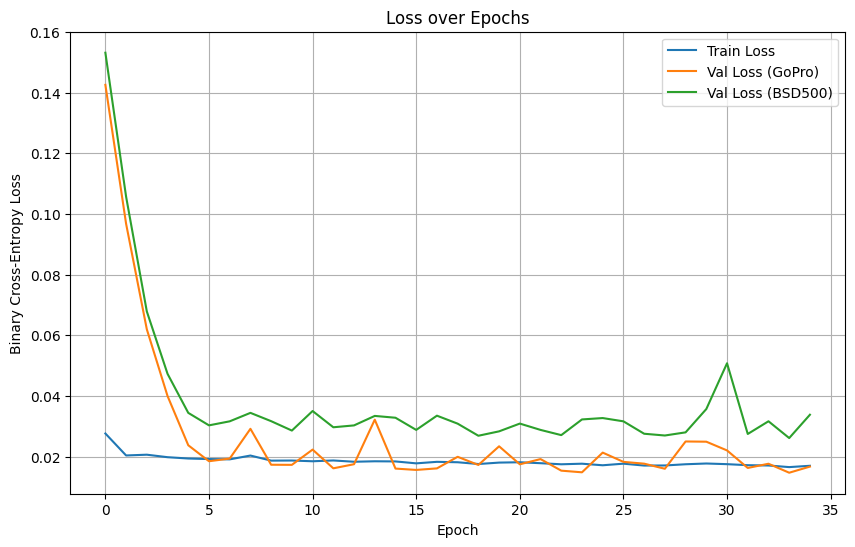

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses_gopro, label="Val Loss (GoPro)")
plt.plot(val_losses_bsd, label="Val Loss (BSD500)")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# === Evaluate PSNR and SSIM on test datasets ===
psnr_gopro, ssim_gopro = evaluate_psnr_ssim(autoencoder, test_dataset_gopro)
psnr_bsd, ssim_bsd = evaluate_psnr_ssim(autoencoder, test_dataset_bsd)

print(f"📷 PSNR (GoPro): {psnr_gopro:.2f}, SSIM (GoPro): {ssim_gopro:.4f}")
print(f"📷 PSNR (BSD500): {psnr_bsd:.2f}, SSIM (BSD500): {ssim_bsd:.4f}")



# === Evaluate on test sets ===
print("Test on GoPro:")
autoencoder.evaluate(test_dataset_gopro)

print("Test on BSD500:")
autoencoder.evaluate(test_dataset_bsd)


W0000 00:00:1745708329.551133   26409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745708329.569630   26409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745708329.570249   26409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745708329.570698   26409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745708329.573065   26409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745708329.585223   26409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745708329.587259   26409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745708329.587720   26409 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745708329.588189   26409 gp

📷 PSNR (GoPro): 27.25, SSIM (GoPro): 0.8531
📷 PSNR (BSD500): 21.99, SSIM (BSD500): 0.5820
Test on GoPro:
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0139
Test on BSD500:
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0342


0.0338786318898201

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


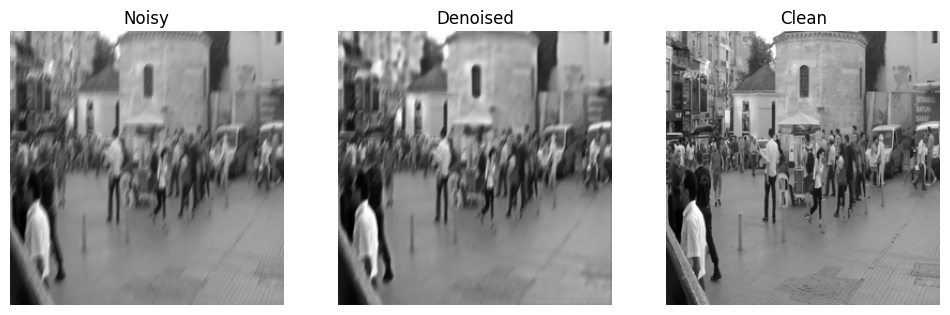

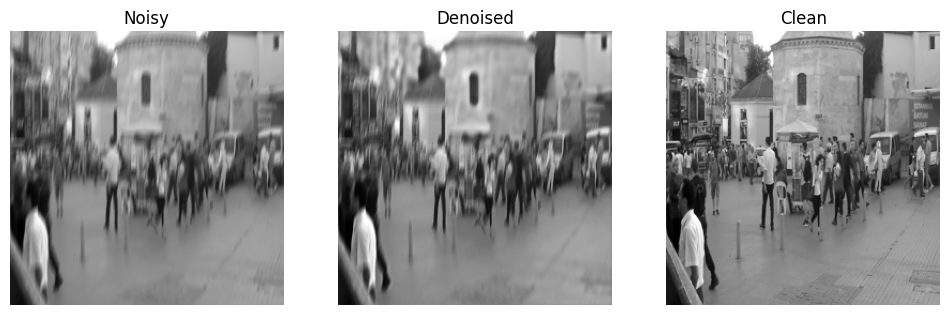

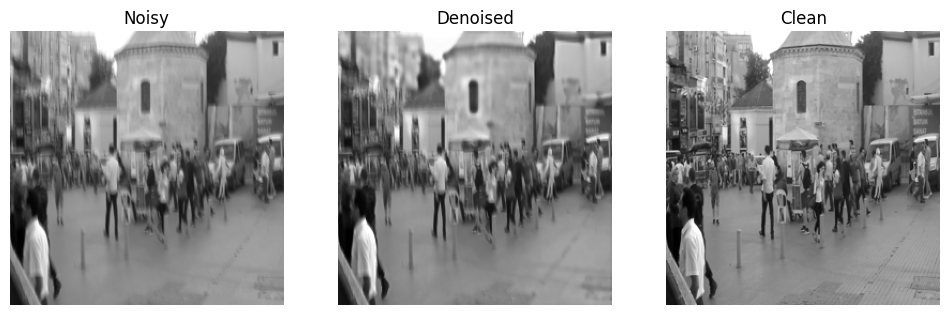

2025-04-26 22:59:23.583557: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# === Visualize a few test results ===
import matplotlib.pyplot as plt

for noisy, clean in test_dataset_gopro.take(1):
    pred = autoencoder.predict(noisy)

    for i in range(3):  # show 3 examples
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Noisy")
        plt.imshow(noisy[i].numpy().squeeze(), cmap='gray')
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Denoised")
        plt.imshow(pred[i].squeeze(), cmap='gray')
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Clean")
        plt.imshow(clean[i].numpy().squeeze(), cmap='gray')
        plt.axis("off")
        plt.show()


References:
https://www.kaggle.com/code/ekojsalim/pres-denoising
https://paperswithcode.com/sota/deblurring-on-gopro
modern: https://www.kaggle.com/code/utkarshsaxenadn/image-denoising-with-auto-encoders
Archaic: https://www.kaggle.com/discussions/questions-and-answers/553140
https://seungjunnah.github.io/Datasets/gopro
https://www.kaggle.com/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500?resource=download